In [16]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import faircat
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from math import comb
import time
import psutil
from scipy.sparse import csgraph


# Stats

In [6]:
# user-defined parameters
dist_type_0="powerlaw"
dist_type_1="powerlaw"
k=5
d=2
corr_targets = {1:-1}

# M: kxk (moderate homophily)
M = np.array([
    [0.4, 0.15, 0.15, 0.15, 0.15],
    [0.15, 0.4, 0.15, 0.15, 0.15],
    [0.15, 0.15, 0.4, 0.15, 0.15],
    [0.15, 0.15, 0.15, 0.4, 0.15],
    [0.15, 0.15, 0.15, 0.15, 0.4],
])

# D: kxk
D = np.array([
    [0.20, 0.05, 0.05, 0.05, 0.05],
    [0.05, 0.20, 0.05, 0.05, 0.05],
    [0.05, 0.05, 0.25, 0.05, 0.05],
    [0.05, 0.05, 0.05, 0.25, 0.05],
    [0.05, 0.05, 0.05, 0.05, 0.30],
])

# H: (d-1) x k - moderate separation
H =np.array([
    [0.4, 0.1, 0.1, 0.4, 0.1]
    ])

# Pcg: g x k that does not change class preferences (from M)
g = 2; #binary sensitive attribute
base = np.array([0.4, 0.15, 0.15, 0.15, 0.15])  # sums to 1 after normalization
Pcg = np.vstack([base, base])                   # shape (g, k)
Pcg /= Pcg.sum(axis=1, keepdims=True)


In [7]:
z=16
deg_0 = 2**z
deg_1 = 2**z

n_0 = int(deg_0 / 32)
n_1 = int(deg_1 / 32)

avg_deg_0 = deg_0 / n_0
avg_deg_1 = deg_1 / n_1
max_deg_0 = int(min(avg_deg_0 * 8, n_0))
max_deg_1 = int(min(avg_deg_1 * 8, n_1))

In [8]:
S, X, Label, theta, sorted_attr_group = faircat.faircat(
            n_0, n_1, deg_0, deg_1,
            k, d, max_deg_0, max_deg_1,
            dist_type_0, dist_type_1,
            Pcg, M, D, H,
            att_type="normal",
            corr_targets=corr_targets,
            MAPE=True
        )


sum of degrees for group (target=65536): 67360
break
sum of degrees for group (target=65536): 81843
saturated attempts: 226986
number of generated edges : 74512
Rescaling adjusted continuous attribute to [0,1]


In [5]:
def inter_intra_counts(S, groups):
    groups = np.asarray(groups)
    intra = {g: 0 for g in np.unique(groups)} 
    inter = {g: 0 for g in np.unique(groups)}

    rows, cols = S.nonzero()
    for r, c in zip(rows, cols):
        if r >= c: 
            continue
        gr, gc = groups[r], groups[c]
        if gr == gc:
            intra[gr] += 1         
        else:
            inter[gr] += 1         
            inter[gc] += 1  

    return intra, inter


In [6]:
intra, inter = inter_intra_counts(S, sorted_attr_group)
print("intra edges:", intra)
print("inter edges per group:", inter)

intra edges: {0: 16960, 1: 16211}
inter edges per group: {0: 33504, 1: 33504}


In [7]:
sorted_attr_group = np.array(sorted_attr_group)
nc_0 = len(sorted_attr_group[sorted_attr_group == 0])
max_possible_0 = comb(nc_0, 2)
nc_1 = len(sorted_attr_group[sorted_attr_group == 1])
max_possible_1 = comb(nc_1, 2)
intra_density = 1/2*(1/max_possible_0*intra[0] + 1/max_possible_1*intra[1])
print("intra-community density:", intra_density)

intra-community density: 0.007912446186492427


In [8]:
inter_density = (inter[0])/(nc_0*nc_1)
print("inter-community density:", inter_density)

inter-community density: 0.00798797607421875


In [ ]:


def lcc_size_numpy(A):
    n_components, labels = csgraph.connected_components(A, directed=False)
    sizes = np.bincount(labels)
    return int(sizes.max()), int(n_components)
print("LCC size:", lcc_size_numpy(S)[0])
print("number of components:", lcc_size_numpy(S)[1])

LCC size: 4096
number of components: 1


In [10]:
def characteristic_path_length(A):
    n_components, labels = csgraph.connected_components(A, directed=False)
    if n_components > 1:
        # pick largest component
        largest = np.argmax(np.bincount(labels))
        keep = np.flatnonzero(labels == largest)
        A = A.tocsr()[keep][:, keep]

    dist = csgraph.shortest_path(A, directed=False, unweighted=True)
    # upper triangle, exclude zeros on diagonal
    i, j = np.triu_indices_from(dist, k=1)
    return dist[i, j].mean()
print("Characteristic path length:", characteristic_path_length(S))

Characteristic path length: 2.8244209783272285


In [11]:
## averages
intra_density_avg = (0.009843625961773326+0.009010900097703958+0.009027597551294578+0.009411638983878846+0.009270426233512458) / 5
inter_density_avg = (0.009807109832763672+0.009015560150146484+0.00893259048461914+0.009334325790405273+0.00916290283203125) / 5
path_length_avg = (2.7260812538156287+2.763311775030525+2.773220963064713+2.729038366147741+2.7639909569597068)/5
print("Averages:")
print("intra-community density avg:", intra_density_avg)
print("inter-community density avg:", inter_density_avg)
print("average path length avg:", path_length_avg)

Averages:
intra-community density avg: 0.009312837765632635
inter-community density avg: 0.009250497817993164
average path length avg: 2.751128663003663


In [11]:
dist_type_0="powerlaw"
dist_type_1="powerlaw"
k=5
d=244

z_pairs = [(21,21), (22, 22),(23, 23), (24, 24), (25, 25)]

# M: kxk (moderate homophily)
M = np.array([
    [0.6, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.6, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.6, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.6, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.6],
])

# D: kxk
D = np.array([
    [0.2, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.2, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.2, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.2, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.2],
])

# H: (d-1) x k - moderate separation
H = np.random.rand(d - 1, k)
H /= H.sum(axis=1, keepdims=True)

# Pcg
g = 2
base = np.array([0.4, 0.15, 0.15, 0.15, 0.15])  # sums to 1 after normalization
Pcg = np.vstack([base, base])                   # shape (g, k)
Pcg /= Pcg.sum(axis=1, keepdims=True)


results = []
process = psutil.Process() 

corr_targets_lengths = [3, 3**2, 3**3, 3**4, 3**5]

for z_0, z_1 in z_pairs:
    for c in corr_targets_lengths:
        print(f"\n=== Running z0={z_0}, z1={z_1}, c={c} ===")

        deg_0 = 2**z_0
        deg_1 = 2**z_1

        n_0 = int(deg_0 / 64)
        n_1 = int(deg_1 / 64)

        avg_deg_0 = deg_0 / n_0
        avg_deg_1 = deg_1 / n_1
        max_deg_0 = int(min(avg_deg_0 * 8, n_0))
        max_deg_1 = int(min(avg_deg_1 * 8, n_1))

        corr_vals = np.random.uniform(-1, 1, size=c) 
        corr_targets = {i+1: v for i, v in enumerate(corr_vals)}

        mem_before = process.memory_info().rss / (1024**3)  # GB
        start = time.time()

        # faircat run
        S, X, Label = faircat.faircat(
            n_0, n_1, deg_0, deg_1,
            k, d, max_deg_0, max_deg_1,
            dist_type_0, dist_type_1,
            Pcg, M, D, H,
            att_type="normal",
            corr_targets=corr_targets
        )

        mem_after = process.memory_info().rss / (1024**3)
        mem_used = mem_after - mem_before


        end = time.time()
        runtime = end - start

        results.append((z_0, z_1, c, runtime, mem_used))
        print(f"Time: {runtime:.1f}s | Memory: {mem_used:.2f} GB")






=== Running z0=21, z1=21, c=3 ===
break
sum of degrees for group (target=2097152): 2169114
break
sum of degrees for group (target=2097152): 2133459
saturated attempts: 7541503
number of generated edges : 2149374
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Time: 272.9s | Memory: 0.64 GB

=== Running z0=21, z1=21, c=9 ===
break
sum of degrees for group (target=2097152): 2149513
break
sum of degrees for group (target=2097152): 2123213
saturated attempts: 7633725
number of generated edges : 2134496
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Resc

In [ ]:
H = np.random.dirichlet(alpha=np.ones(k), size=d - 1)

In [ ]:
print(H)

[[0.03784687 0.27260427 0.02397269 0.36344451 0.30213166]
 [0.18882137 0.05887833 0.35054192 0.11002043 0.29173795]
 [0.63565619 0.14204005 0.15364575 0.06476956 0.00388844]
 ...
 [0.23325724 0.07815458 0.59440045 0.05144363 0.0427441 ]
 [0.23195018 0.33793097 0.07914489 0.01566259 0.33531137]
 [0.11877644 0.03413285 0.37177688 0.22546474 0.24984909]]


In [ ]:
corr_vals = np.random.uniform(-1, 1, size=1) 
corr_targets_list = {i+1: v for i, v in enumerate(corr_vals)}

  
print(corr_targets_list)

{1: np.float64(0.31027973614114135)}


# Balancing

In [ ]:
# define the (deg0, deg1) exponent pairs
z_pairs = [(16, 16), (17, 17), (18, 18), (19, 19), (20, 20)]
balance_configs = [
    ("balanced", 1.0, 1.0),   # 50–50 groups
    ("mild_imbalance", 1.4, 0.7),  # 30–70 groups
    ("strong_imbalance", 1.8, 0.2) # 10–90 groups
]

results = []

for z_0, z_1 in z_pairs:
    for label, a0, a1 in balance_configs:
        print(f"\n=== Running z0={z_0}, z1={z_1} | config={label} ===")

        deg_0 = a0 * (2**z_0)
        deg_1 = a1 * (2**z_1)

        n_0 = int(deg_0 / 32)
        n_1 = int(deg_1 / 32)

        avg_deg_0 = deg_0 / n_0
        avg_deg_1 = deg_1 / n_1
        max_deg_0 = int(min(avg_deg_0 * 8, n_0))
        max_deg_1 = int(min(avg_deg_1 * 8, n_1))

        start = time.time()

        # faircat run
        S, X, Label, theta, sorted_attr_group = faircat.faircat(
            n_0, n_1, deg_0, deg_1,
            k, d, max_deg_0, max_deg_1,
            dist_type_0, dist_type_1,
            Pcg, M, D, H,
            att_type="normal",
            corr_targets=corr_targets,
            MAPE=True
        )

        # Compute mape
        S = S.tocsr()
        S.setdiag(0)
        if hasattr(S, "eliminate_zeros"):
            S.eliminate_zeros()
        if S.nnz:
            S.data[:] = 1

        theta_actual = np.array(S.sum(axis=1)).ravel().astype(float)
        theta_target = np.asarray(theta, float)
        theta_target = np.clip(theta_target, 1e-12, None)
        mape_total = np.mean(np.abs(theta_actual - theta_target) / theta_target)

        g = np.asarray(sorted_attr_group)
        mape_0 = np.mean(np.abs(theta_actual[g==0] - theta_target[g==0]) / theta_target[g==0])
        mape_1 = np.mean(np.abs(theta_actual[g==1] - theta_target[g==1]) / theta_target[g==1])

        end = time.time()
        runtime = end - start

        # results
        results.append((z_0, z_1, label, mape_total, mape_0, mape_1, runtime))
        print(f"MAPE overall: {mape_total:.2e} | g0: {mape_0:.2e} | g1: {mape_1:.2e} | Time: {runtime:.1f}s")

print("\n===== MAPE Summary =====")
print("z0\tz1\tconfig\tMAPE_total\tMAPE_g0\tMAPE_g1\tRuntime[s]")
for z0, z1, cfg, mt, m0, m1, t in results:
    print(f"{z0}\t{z1}\t{cfg}\t{mt:.2e}\t{m0:.2e}\t{m1:.2e}\t{t:.1f}")



=== Running z0=16, z1=16 | config=strong_imbalance ===
break
sum of degrees for group (target=117964.8): 142798
sum of degrees for group (target=13107.2): 13978
saturated attempts: 224968
number of generated edges : 78294
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to [0,1]
Rescaling adjusted continuous attribute to

# Degree distribution types

In [ ]:
# user-defined parameters
k=5
d=2
corr_targets = {}

# M: kxk (moderate homophily)
M = np.array([
    [0.4, 0.15, 0.15, 0.15, 0.15],
    [0.15, 0.4, 0.15, 0.15, 0.15],
    [0.15, 0.15, 0.4, 0.15, 0.15],
    [0.15, 0.15, 0.15, 0.4, 0.15],
    [0.15, 0.15, 0.15, 0.15, 0.4],
])

# D: kxk
D = np.array([
    [0.20, 0.05, 0.05, 0.05, 0.05],
    [0.05, 0.20, 0.05, 0.05, 0.05],
    [0.05, 0.05, 0.25, 0.05, 0.05],
    [0.05, 0.05, 0.05, 0.25, 0.05],
    [0.05, 0.05, 0.05, 0.05, 0.30],
])

# H: (d-1) x k - moderate separation
H =np.array([
    [0.4, 0.1, 0.1, 0.4, 0.1]
    ])

# Pcg
g = 2; k = 5 #binary sensitive attribute
base = np.array([0.4, 0.15, 0.15, 0.15, 0.15])  # sums to 1 after normalization
Pcg = np.vstack([base, base])                   # shape (g, k)
Pcg /= Pcg.sum(axis=1, keepdims=True)


In [ ]:
# define the (deg0, deg1) exponent pairs
z_pairs = [(16, 16), (17, 17), (18, 18), (19, 19), (20, 20)]
dist_type_configs = [
    ("normal", "normal", "normal"), 
    ("uniform", "uniform", "uniform"), 
    ("mixed: powerlaw_normal", "powerlaw", "normal"),
    ("mixed: powerlaw_uniform", "powerlaw", "uniform"),
    ("mixed: normal_uniform", "normal", "uniform")
]

results = []

for z_0, z_1 in z_pairs:
    for label, a0, a1 in dist_type_configs:
        print(f"\n=== Running z0={z_0}, z1={z_1} | config={label} ===")

        deg_0 =  (2**z_0)
        deg_1 =  (2**z_1)

        n_0 = int(deg_0 / 32)
        n_1 = int(deg_1 / 32)

        avg_deg_0 = deg_0 / n_0
        avg_deg_1 = deg_1 / n_1
        max_deg_0 = int(min(avg_deg_0 * 8, n_0))
        max_deg_1 = int(min(avg_deg_1 * 8, n_1))

        dist_type_0 = a0
        dist_type_1 = a1
        start = time.time()

        S, X, Label, theta, sorted_attr_group = faircat.faircat(
            n_0, n_1, deg_0, deg_1,
            k, d, max_deg_0, max_deg_1,
            dist_type_0, dist_type_1,
            Pcg, M, D, H,
            att_type="normal",
            corr_targets=corr_targets,
            MAPE=True
        )

        # Compute mape
        S = S.tocsr()
        S.setdiag(0)
        if hasattr(S, "eliminate_zeros"):
            S.eliminate_zeros()
        if S.nnz:
            S.data[:] = 1

        theta_actual = np.array(S.sum(axis=1)).ravel().astype(float)
        theta_target = np.asarray(theta, float)
        theta_target = np.clip(theta_target, 1e-12, None)
        mape_total = np.mean(np.abs(theta_actual - theta_target) / theta_target)

        g = np.asarray(sorted_attr_group)
        mape_0 = np.mean(np.abs(theta_actual[g==0] - theta_target[g==0]) / theta_target[g==0])
        mape_1 = np.mean(np.abs(theta_actual[g==1] - theta_target[g==1]) / theta_target[g==1])

        end = time.time()
        runtime = end - start

        results.append((z_0, z_1, label, mape_total, mape_0, mape_1, runtime))
        print(f"MAPE overall: {mape_total:.2e} | g0: {mape_0:.2e} | g1: {mape_1:.2e} | Time: {runtime:.1f}s")

print("\n===== MAPE Summary =====")
print("z0\tz1\tconfig\tMAPE_total\tMAPE_g0\tMAPE_g1\tRuntime[s]")
for z0, z1, cfg, mt, m0, m1, t in results:
    print(f"{z0}\t{z1}\t{cfg}\t{mt:.2e}\t{m0:.2e}\t{m1:.2e}\t{t:.1f}")



=== Running z0=16, z1=16 | config=normal ===
sum of degrees for group (target=65536): 65566
sum of degrees for group (target=65536): 66570
number of generated edges : 66030
MAPE overall: 7.50e-04 | g0: 1.03e-03 | g1: 4.73e-04 | Time: 4.9s

=== Running z0=16, z1=16 | config=uniform ===
sum of degrees for group (target=65536): 65046
sum of degrees for group (target=65536): 64794
number of generated edges : 64883
MAPE overall: 6.39e-04 | g0: 5.08e-04 | g1: 7.71e-04 | Time: 5.2s

=== Running z0=16, z1=16 | config=mixed: powerlaw_normal ===
break
sum of degrees for group (target=65536): 76985
sum of degrees for group (target=65536): 65292
number of generated edges : 71098
MAPE overall: 6.36e-04 | g0: 4.98e-04 | g1: 7.73e-04 | Time: 5.7s

=== Running z0=16, z1=16 | config=mixed: powerlaw_uniform ===
break
sum of degrees for group (target=65536): 79449
sum of degrees for group (target=65536): 65118
number of generated edges : 72244
MAPE overall: 5.29e-04 | g0: 2.16e-04 | g1: 8.43e-04 | Time:

## max degree difference

In [ ]:
dist_type_0="normal"
dist_type_1="normal"

results = []

z_0=20
z_1=20

max_deg_multiplier = [(2**1), (2**2), (2**3), (2**4), (2**5), (2**6), (2**7), (2**8), (2**9), (2**10)]

for i in max_deg_multiplier:
    print(f"\n=== Running z0={z_0}, z1={z_1} | multiplier={i} ===")

    deg_0 =  (2**z_0)
    deg_1 =  (2**z_1)

    n_0 = int(deg_0 / 32)
    n_1 = int(deg_1 / 32)

    avg_deg_0 = deg_0 / n_0
    avg_deg_1 = deg_1 / n_1
    max_deg_0 = int(avg_deg_0 * i)
    max_deg_1 = int(avg_deg_1 * i)

    start = time.time()


    # faircat run
    S, X, Label, theta, sorted_attr_group = faircat.faircat(
        n_0, n_1, deg_0, deg_1,
        k, d, max_deg_0, max_deg_1,
        dist_type_0, dist_type_1,
        Pcg, M, D, H,
        att_type="normal",
        corr_targets=corr_targets,
        MAPE=True
    )

    # Compute mape
    S = S.tocsr()
    S.setdiag(0)
    if hasattr(S, "eliminate_zeros"):
        S.eliminate_zeros()
    if S.nnz:
        S.data[:] = 1

    theta_actual = np.array(S.sum(axis=1)).ravel().astype(float)
    theta_target = np.asarray(theta, float)
    theta_target = np.clip(theta_target, 1e-12, None)
    mape_total = np.mean(np.abs(theta_actual - theta_target) / theta_target)

    g = np.asarray(sorted_attr_group)
    mape_0 = np.mean(np.abs(theta_actual[g==0] - theta_target[g==0]) / theta_target[g==0])
    mape_1 = np.mean(np.abs(theta_actual[g==1] - theta_target[g==1]) / theta_target[g==1])

    end = time.time()
    runtime = end - start

    results.append((z_0, z_1, i, mape_total, mape_0, mape_1, runtime))
    print(f"MAPE overall: {mape_total:.2e} | g0: {mape_0:.2e} | g1: {mape_1:.2e} | Time: {runtime:.1f}s")

print("\n===== MAPE Summary =====")
print("z0\tz1\tconfig\tMAPE_total\tMAPE_g0\tMAPE_g1\tRuntime[s]")
for z0, z1, cfg, mt, m0, m1, t in results:
    print(f"{z0}\t{z1}\t{cfg}\t{mt:.2e}\t{m0:.2e}\t{m1:.2e}\t{t:.1f}")



=== Running z0=20, z1=20 | multiplier=2 ===
sum of degrees for group (target=1048576): 1054593
sum of degrees for group (target=1048576): 1051958
saturated attempts: 1030086
number of generated edges : 1052688
MAPE overall: 7.16e-04 | g0: 7.35e-04 | g1: 6.96e-04 | Time: 87.0s

=== Running z0=20, z1=20 | multiplier=4 ===
sum of degrees for group (target=1048576): 1051030
sum of degrees for group (target=1048576): 1055452
saturated attempts: 1029423
number of generated edges : 1052688
MAPE overall: 6.77e-04 | g0: 6.21e-04 | g1: 7.33e-04 | Time: 81.0s

=== Running z0=20, z1=20 | multiplier=8 ===
sum of degrees for group (target=1048576): 1051758
sum of degrees for group (target=1048576): 1055796
saturated attempts: 1018605
number of generated edges : 1053224
MAPE overall: 6.73e-04 | g0: 6.65e-04 | g1: 6.82e-04 | Time: 81.7s

=== Running z0=20, z1=20 | multiplier=16 ===
sum of degrees for group (target=1048576): 1054102
sum of degrees for group (target=1048576): 1057183
saturated attempts

# Target correlation

In [ ]:
k=5
d=2
dist_type_0="powerlaw"
dist_type_1="powerlaw"

# M: kxk (moderate homophily)
M = np.array([
    [0.4, 0.15, 0.15, 0.15, 0.15],
    [0.15, 0.4, 0.15, 0.15, 0.15],
    [0.15, 0.15, 0.4, 0.15, 0.15],
    [0.15, 0.15, 0.15, 0.4, 0.15],
    [0.15, 0.15, 0.15, 0.15, 0.4],
])

# D: kxk
D = np.array([
    [0.20, 0.05, 0.05, 0.05, 0.05],
    [0.05, 0.20, 0.05, 0.05, 0.05],
    [0.05, 0.05, 0.25, 0.05, 0.05],
    [0.05, 0.05, 0.05, 0.25, 0.05],
    [0.05, 0.05, 0.05, 0.05, 0.30],
])

# H: (d-1) x k - moderate separation
H =np.array([
    [0.4, 0.1, 0.1, 0.4, 0.1]
    ])

# Pcg
g = 2; k = 5 #binary sensitive attribute
base = np.array([0.4, 0.15, 0.15, 0.15, 0.15])  # sums to 1 after normalization
Pcg = np.vstack([base, base])                   # shape (g, k)
Pcg /= Pcg.sum(axis=1, keepdims=True)


In [ ]:
z_pairs = [(16, 16), (17, 17), (18, 18), (19, 19), (20, 20)]
correlation_configs = [
    ("low", {1: 0.05}),
    ("medium", {1: 0.5}),
    ("high", {1: 0.95}),
]
    
results = []

for z_0, z_1 in z_pairs:
    for label, corr in correlation_configs:
        print(f"\n=== Running z0={z_0}, z1={z_1} | config={label} ===")

        deg_0 =  (2**z_0)
        deg_1 =  (2**z_1)

        n_0 = int(deg_0 / 32)
        n_1 = int(deg_1 / 32)

        avg_deg_0 = deg_0 / n_0
        avg_deg_1 = deg_1 / n_1
        max_deg_0 = int(min(avg_deg_0 * 8, n_0))
        max_deg_1 = int(min(avg_deg_1 * 8, n_1))

        start = time.time()

        corr_targets = corr
        # faircat run
        S, X, Label, theta, sorted_attr_group = faircat.faircat(
            n_0, n_1, deg_0, deg_1,
            k, d, max_deg_0, max_deg_1,
            dist_type_0, dist_type_1,
            Pcg, M, D, H,
            att_type="normal",
            corr_targets=corr_targets,
            MAPE=True
        )

        # Compute mape
        S = S.tocsr()
        S.setdiag(0)
        if hasattr(S, "eliminate_zeros"):
            S.eliminate_zeros()
        if S.nnz:
            S.data[:] = 1

        theta_actual = np.array(S.sum(axis=1)).ravel().astype(float)
        theta_target = np.asarray(theta, float)
        theta_target = np.clip(theta_target, 1e-12, None)
        mape_total = np.mean(np.abs(theta_actual - theta_target) / theta_target)

        g = np.asarray(sorted_attr_group)
        mape_0 = np.mean(np.abs(theta_actual[g==0] - theta_target[g==0]) / theta_target[g==0])
        mape_1 = np.mean(np.abs(theta_actual[g==1] - theta_target[g==1]) / theta_target[g==1])

        s = X[:, 0].astype(float)        # sensitive attribute (column 0)
        x_target = X[:, 1].astype(float) # non-sensitive attribute

        # actual correlation
        corr_actual = np.corrcoef(s, x_target)[0, 1]

        # target correlation
        target_corr = list(corr_targets.values())[0]

        print(f"Target corr={target_corr:.2f} | Actual corr={corr_actual:.3f} | Diff={abs(corr_actual - target_corr):.3e}")

        end = time.time()
        runtime = end - start

        results.append((z_0, z_1, label, mape_total, mape_0, mape_1, runtime, target_corr, corr_actual))


        


        print(f"MAPE overall: {mape_total:.2e} | g0: {mape_0:.2e} | g1: {mape_1:.2e} | Time: {runtime:.1f}s")

print("\n===== Summary =====")
print("z0\tz1\tconfig\tMAPE_total\tMAPE_g0\tMAPE_g1\tTarget_corr\tActual_corr\tRuntime[s]")
for z0, z1, cfg, mt, m0, m1, t, tc, ac in results:
    print(f"{z0}\t{z1}\t{cfg}\t{mt:.2e}\t{m0:.2e}\t{m1:.2e}\t{tc:.2f}\t{ac:.3f}\t{t:.1f}")




=== Running z0=16, z1=16 | config=low ===
break
sum of degrees for group (target=65536): 78887
break
sum of degrees for group (target=65536): 82117
number of generated edges : 80404
Rescaling adjusted continuous attribute to [0,1]
Target corr=0.05 | Actual corr=0.050 | Diff=4.857e-17
MAPE overall: 6.12e-04 | g0: 8.12e-04 | g1: 4.12e-04 | Time: 4.9s

=== Running z0=16, z1=16 | config=medium ===
break
sum of degrees for group (target=65536): 72684
break
sum of degrees for group (target=65536): 80352
number of generated edges : 76424
Rescaling adjusted continuous attribute to [0,1]
Target corr=0.50 | Actual corr=0.500 | Diff=0.000e+00
MAPE overall: 6.02e-04 | g0: 5.57e-04 | g1: 6.48e-04 | Time: 4.7s

=== Running z0=16, z1=16 | config=high ===
break
sum of degrees for group (target=65536): 75879
sum of degrees for group (target=65536): 67619
number of generated edges : 71637
Rescaling adjusted continuous attribute to [0,1]
Target corr=0.95 | Actual corr=0.950 | Diff=0.000e+00
MAPE overall

# Scaling

In [ ]:
dist_type_0="powerlaw"
dist_type_1="powerlaw"
k=5
d=2
corr_targets = {}

# M: kxk (moderate homophily)
M = np.array([
    [0.6, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.6, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.6, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.6, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.6],
])

# D: kxk
D = np.array([
    [0.2, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.2, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.2, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.2, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.2],
])

# H: (d-1) x k - moderate separation
H =np.array([
    [0.4, 0.1, 0.1, 0.4, 0.1]
    ])

# Pcg
g = 2
base = np.array([0.4, 0.15, 0.15, 0.15, 0.15])  # sums to 1 after normalization
Pcg = np.vstack([base, base])                   # shape (g, k)
Pcg /= Pcg.sum(axis=1, keepdims=True)


In [ ]:

z_pairs = [(21, 21)]

results = []

process = psutil.Process() 

for z_0, z_1 in z_pairs:
    print(f"\n=== Running z0={z_0}, z1={z_1} ===")

    deg_0 = 2**z_0
    deg_1 = 2**z_1

    n_0 = int(deg_0 / 64)
    n_1 = int(deg_1 / 64)

    avg_deg_0 = deg_0 / n_0
    avg_deg_1 = deg_1 / n_1
    max_deg_0 = int(min(avg_deg_0 * 8, n_0))
    max_deg_1 = int(min(avg_deg_1 * 8, n_1))

    mem_before = process.memory_info().rss / (1024**3)  # GB
    start = time.time()

    # faircat run
    S, X, Label = faircat.faircat(
        n_0, n_1, deg_0, deg_1,
        k, d, max_deg_0, max_deg_1,
        dist_type_0, dist_type_1,
        Pcg, M, D, H,
        att_type="normal",
        corr_targets=corr_targets
    )

    mem_after = process.memory_info().rss / (1024**3)
    mem_used = mem_after - mem_before


    end = time.time()
    runtime = end - start

    # results 
    results.append((z_0, z_1, runtime, mem_used))
    pd.DataFrame(results).to_csv("faircat_progress.csv", index=False)
    print(f"Time: {runtime:.1f}s | Memory: {mem_used:.2f} GB")

# summary table 
print("\n===== MAPE + Memory Summary =====")
print("z0\tz1\tRuntime[s]\tMemory[GB]")
for z0, z1, t, mem in results:
    print(f"{z0}\t{z1}\t{t:.1f}\t{mem:.2f}")



=== Running z0=21, z1=21 ===
break
sum of degrees for group (target=2097152): 2159641
break
sum of degrees for group (target=2097152): 2154923
number of generated edges : 2155302
Time: 103.9s | Memory: 1.02 GB

===== MAPE + Memory Summary =====
z0	z1	Runtime[s]	Memory[GB]
21	21	103.9	1.02


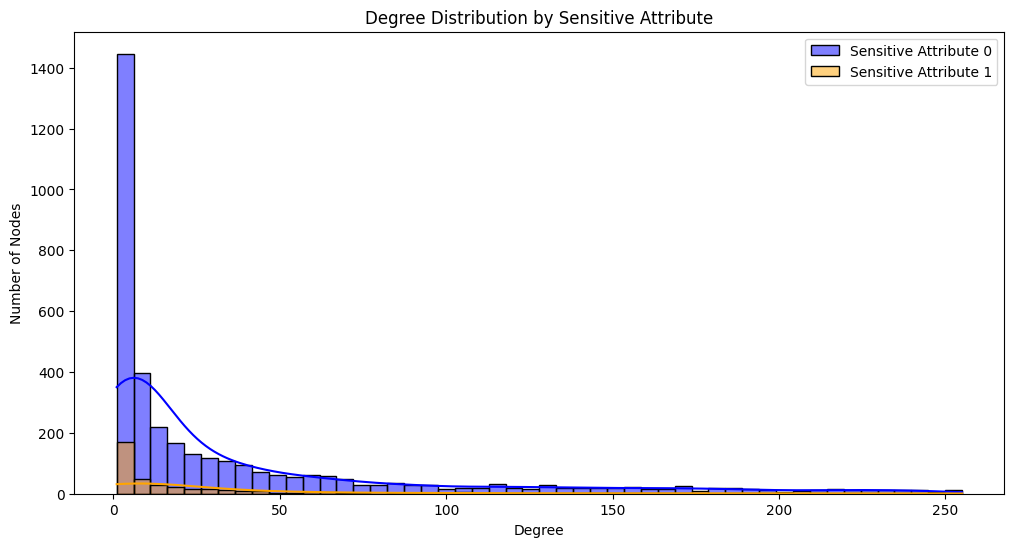

In [15]:

deg_sequence = np.array(S.sum(axis=1)).flatten()
deg_0_sequence = np.array(S[X[:, 0] == 0].sum(axis=1)).flatten()
deg_1_sequence = np.array(S[X[:, 0] == 1].sum(axis=1)).flatten()
plt.figure(figsize=(12, 6))
sns.histplot(deg_0_sequence, bins=50, color='blue', label='Sensitive Attribute 0', kde=True)
sns.histplot(deg_1_sequence, bins=50, color='orange', label='Sensitive Attribute 1', kde=True)
plt.title('Degree Distribution by Sensitive Attribute')

plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.legend()

